<a href="https://colab.research.google.com/github/faisal-rasheed-lone/Neural-Networks-And-Deep-Learning/blob/master/LeNeT_implememntation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile

# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-10-08 16:12:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 74.125.199.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  44.5MB/s    in 6.6s    

2023-10-08 16:12:29 (74.6 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [2]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [3]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [42]:
import os
import shutil
import random

# Define the paths to your data directories
test_dir = '/content/10_food_classes_all_data/test'  # Replace with the path to your test directory
validation_dir = '/content/10_food_classes_all_data/validation'  # Replace with the path to your validation directory

# Create the validation directory if it doesn't exist
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)

# Define the list of class directories (assuming one subdirectory per class)
class_directories = os.listdir(test_dir)

# Specify the percentage of images to move to the validation set (e.g., 20%)
validation_percentage = 0.5

# Iterate through each class directory
for class_directory in class_directories:
    class_test_dir = os.path.join(test_dir, class_directory)
    class_validation_dir = os.path.join(validation_dir, class_directory)

    # Create the class-specific validation directory if it doesn't exist
    if not os.path.exists(class_validation_dir):
        os.mkdir(class_validation_dir)

    # List all image files in the class-specific test directory
    images = os.listdir(class_test_dir)

    # Calculate the number of images to move to the validation set
    num_validation_images = int(len(images) * validation_percentage)

    # Randomly select images to move to the validation set
    validation_images = random.sample(images, num_validation_images)

    # Move the selected validation images to the validation directory
    for img in validation_images:
        src = os.path.join(class_test_dir, img)
        dst = os.path.join(class_validation_dir, img)
        shutil.move(src, dst)

print("Validation set created successfully.")


Validation set created successfully.


In [43]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (384, 512, 3)


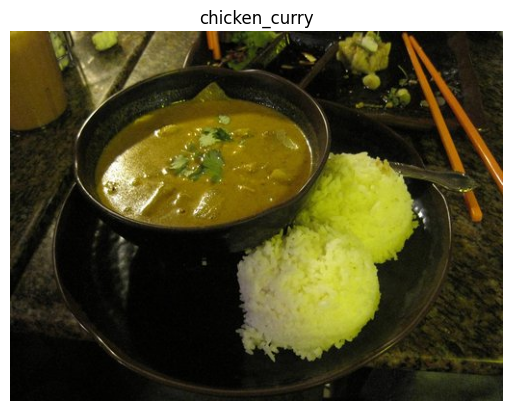

In [44]:
# View a random image from the training dataset

img = view_random_image(target_dir=train_dir,target_class=random.choice(class_names)) # get a random class name

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [47]:
# Define a random seed for reproducibility
seed = 42

# Rescale the data and create data generator instances with augmentations
train_datagen = ImageDataGenerator(
   rescale=1/255.,
   rotation_range=20,         # Randomly rotate images by up to 20 degrees
   width_shift_range=0.2,     # Randomly shift images horizontally by up to 20% of the width
   height_shift_range=0.2,    # Randomly shift images vertically by up to 20% of the height
   shear_range=0.2,           # Randomly apply shear transformations
   zoom_range=0.2,            # Randomly zoom in by up to 20%
   horizontal_flip=True,      # Randomly flip images horizontally
   fill_mode='nearest'
 )

test_datagen = ImageDataGenerator(rescale=1/255.)  # Only rescale for the test data
valid_datagen = ImageDataGenerator(rescale=1/255.)  # Only rescale for the test data

# Load data from directories and turn it into batches with seed settings
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(227, 227),
    batch_size=64,
    class_mode='categorical',  # For multiclass classification
    seed=seed  # Set seed for reproducibility
)
validation_data = valid_datagen.flow_from_directory(
    validation_dir,
    target_size=(227, 227),
    batch_size=64,
    class_mode='categorical',  # For multiclass classification
    seed=seed  # Set seed for reproducibility
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(227, 227),
    batch_size=64,
    class_mode='categorical',  # For multiclass classification
    seed=seed  # Set seed for reproducibility
)


Found 7500 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [48]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import os
import time

In [49]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [50]:
# Compile the model
model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_9 (Bat  (None, 55, 55, 96)        384       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_10 (Ba  (None, 27, 27, 256)       1024      
 tchNormalization)                                               
                                                      

In [52]:
# Adding Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Fit the model
history =model.fit(train_data, # now 10 different classes
                        epochs=50,
                        steps_per_epoch=len(train_data),
                        validation_data=validation_data,
                        validation_steps=len(validation_data),
                        callbacks=[checkpoint, early_stopping])

Epoch 1/50
118/118 [==============================] - ETA: 0s - loss: 6.5747 - accuracy: 0.1393
Epoch 1: val_loss improved from inf to 2.74467, saving model to best_model.h5
118/118 [==============================] - 129s 1s/step - loss: 6.5747 - accuracy: 0.1393 - val_loss: 2.7447 - val_accuracy: 0.1087
Epoch 2/50
118/118 [==============================] - ETA: 0s - loss: 2.3277 - accuracy: 0.1651
Epoch 2: val_loss improved from 2.74467 to 2.21669, saving model to best_model.h5
118/118 [==============================] - 123s 1s/step - loss: 2.3277 - accuracy: 0.1651 - val_loss: 2.2167 - val_accuracy: 0.1807
Epoch 3/50
118/118 [==============================] - ETA: 0s - loss: 2.2619 - accuracy: 0.1940
Epoch 3: val_loss improved from 2.21669 to 2.14885, saving model to best_model.h5
118/118 [==============================] - 124s 1s/step - loss: 2.2619 - accuracy: 0.1940 - val_loss: 2.1489 - val_accuracy: 0.2120
Epoch 4/50
118/118 [==============================] - ETA: 0s - loss: 2.23

In [1]:
import matplotlib.pyplot as plt

# Get the training history
history_dict = history.history

# Plot training and validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


NameError: ignored

In [15]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=227):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [16]:
class_names = ['chicken_curry','chicken_wings','fried_rice','grilled_salmon','hamburger','ice_cream','pizza','ramen','steak','sushi']


In [17]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [18]:
# -q is for "quiet"
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

1/1 [==============================] - 0s 26ms/step


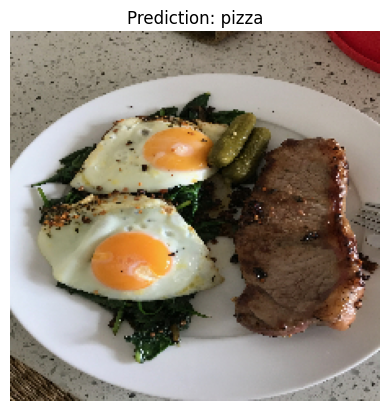

In [24]:
pred_and_plot(alexnet_model, "03-steak.jpeg", class_names)